# Loading Modules

In [10]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
from skimage import io
import numpy as np
from glob import glob
from scipy import misc
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image


In [11]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization

# Loading And Visualizing Data

In [12]:
data = glob('/tmp/train_data/*')

In [13]:
len(data)

800

In [16]:
# load images and store it in list after conversion
images = []
def read_images(data):
    for i in range(len(data)):
        img = io.imread(data[i])
        img = transform.resize(img,(224,224))
        images.append(img)
    return images

In [17]:
read_images(data)

[array([[1.        , 1.        , 1.        , ..., 0.5090036 , 0.72196879,
         0.83889556],
        [1.        , 1.        , 1.        , ..., 0.2545018 , 0.39207683,
         0.48163265],
        [1.        , 1.        , 1.        , ..., 0.        , 0.04441777,
         0.08883553],
        ...,
        [0.99719888, 0.98879552, 0.98039216, ..., 0.34661865, 0.33085234,
         0.32052821],
        [0.96870748, 0.97062825, 0.97591036, ..., 0.22729092, 0.16542617,
         0.13589436],
        [0.94133653, 0.95694278, 0.97927171, ..., 0.15598239, 0.09555822,
         0.14237695]]),
 array([[1.        , 1.        , 1.        , ..., 0.79239696, 0.86266507,
         0.91356543],
        [1.        , 1.        , 1.        , ..., 0.67210884, 0.77334934,
         0.84081633],
        [1.        , 1.        , 1.        , ..., 0.40632253, 0.54237695,
         0.65618247],
        ...,
        [0.        , 0.        , 0.        , ..., 0.78191277, 0.88891557,
         0.93861545],
        [0. 

In [19]:
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
images_arr.shape

(800, 224, 224)

# Data Exploration

In [20]:
# shape of data
print('Dataset Shape : {shape}'.format(shape = images_arr.shape))

Dataset Shape : (800, 224, 224)


First 3 Images:


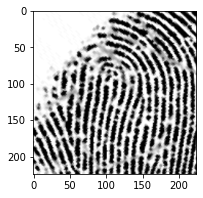

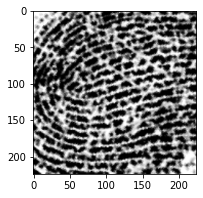

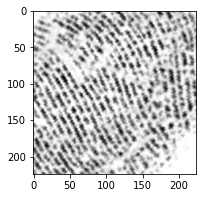

In [21]:
print('First 3 Images:')
# Display the first image in training data
for i in range(3):
    plt.figure(figsize=[3, 3])
    curr_img = np.reshape(images_arr[i], (224,224))
    plt.imshow(curr_img, cmap='gray')
    plt.show()

# Data Pre Processing

In [22]:
# converting image of size (224 , 224 ) to matrix of dimension (224 , 224 ,1)
images_arr = images_arr.reshape(-1 , 224 ,224 , 1)
print('Converted Images Shape :' , images_arr.shape )

Converted Images Shape : (800, 224, 224, 1)


In [23]:
# Checking Data Type
print('Data Type Of Images : ' , images_arr.dtype)

Data Type Of Images :  float32


In [27]:
# Rescaling Images i.e dividing data/max(data_max) i.e pixel/ max_pixel value

print('Max_value :', np.max(images_arr))
      
images_arr = images_arr / np.max(images_arr)
print(images_arr[1])

Max_value : 1.0
[[[1.        ]
  [1.        ]
  [1.        ]
  ...
  [0.79239696]
  [0.86266506]
  [0.9135654 ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [0.6721088 ]
  [0.77334934]
  [0.8408163 ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [0.40632254]
  [0.54237694]
  [0.65618247]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.78191274]
  [0.88891554]
  [0.93861544]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.8004802 ]
  [0.8613045 ]
  [0.8867547 ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.8177671 ]
  [0.84137654]
  [0.8502601 ]]]


# Spltting data For Training And Testing

#### for this task, you don't need training and testing labels. That's why you will pass the training images twice. Your training images will both act as the input , as well as the ground truth similar to the labels you have in the classification task.

>train_X , valid_X - training and testing data data

>valid_ground , train_ground - classification labels .


In [28]:
# splittiong data using sklearn's train_test_split

from sklearn.model_selection import train_test_split

train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr ,
                                                      images_arr ,
                                                      test_size = 0.2,
                                                      random_state = 15) # vaidation_data


# Auto Encoder 

In [34]:
batch_size = 128
epochs = 200
inChannel = 1
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))

## Structure Of Auto Encoder

### Encoder

>The first layer will have 32 filters of size 3 x 3, followed by a downsampling (max-pooling) layer,

>The second layer will have 64 filters of size 3 x 3, followed by another 
downsampling layer,

>The final layer of encoder will have 128 filters of size 3 x 3.


### Decoder

>The first layer will have 128 filters of size 3 x 3 followed by an upsampling layer,

>The second layer will have 64 filters of size 3 x 3 followed by another upsampling layer,

>The final layer of encoder will have one filter of size 3 x 3.


### The max-pooling layer will downsample the input by two times each time you use it, while the upsampling layer will upsample the input by two times each time it is used.


> Note: The number of filters, the filter size, the number of layers, number of epochs you train your model, are all hyperparameters and should be decided  by experimenting , feel free to change:)



In [35]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    encoder_last = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_last) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [36]:
encoder = Model(input_img, autoencoder(input_img))

In [37]:
encoder.compile(loss='mean_squared_error', optimizer = RMSprop())
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 128)      

In [38]:
encoder_train = encoder.fit(train_X ,
                            train_ground , 
                            batch_size = batch_size , 
                            epochs = epochs ,
                            verbose = 1,
                            validation_data =(valid_X, valid_ground))

Epoch 1/200
5/5 [==============================] - 3s 509ms/step - loss: 0.1516 - val_loss: 0.1060
Epoch 2/200
5/5 [==============================] - 3s 590ms/step - loss: 0.1292 - val_loss: 0.1094
Epoch 3/200
5/5 [==============================] - 3s 593ms/step - loss: 0.1170 - val_loss: 0.0927
Epoch 4/200
5/5 [==============================] - 3s 595ms/step - loss: 0.0738 - val_loss: 0.1539
Epoch 5/200
5/5 [==============================] - 3s 601ms/step - loss: 0.1023 - val_loss: 0.0369
Epoch 6/200
5/5 [==============================] - 3s 604ms/step - loss: 0.0910 - val_loss: 0.0588
Epoch 7/200
5/5 [==============================] - 3s 601ms/step - loss: 0.0377 - val_loss: 0.0241
Epoch 8/200
5/5 [==============================] - 3s 607ms/step - loss: 0.0317 - val_loss: 0.1243
Epoch 9/200
5/5 [==============================] - 3s 607ms/step - loss: 0.0440 - val_loss: 0.0208
Epoch 10/200
5/5 [==============================] - 3s 612ms/step - loss: 0.0221 - val_loss: 0.0400
Epoch 11/

# Plotting Loss And Val Loss

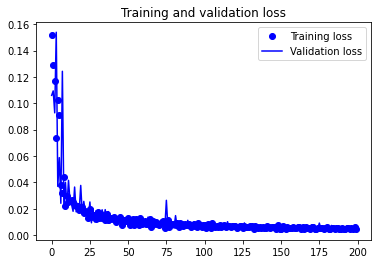

In [40]:
loss = encoder_train.history['loss']
val_loss = encoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Predict On Validation Data

In [41]:
pred = encoder.predict(valid_X)

Test Images


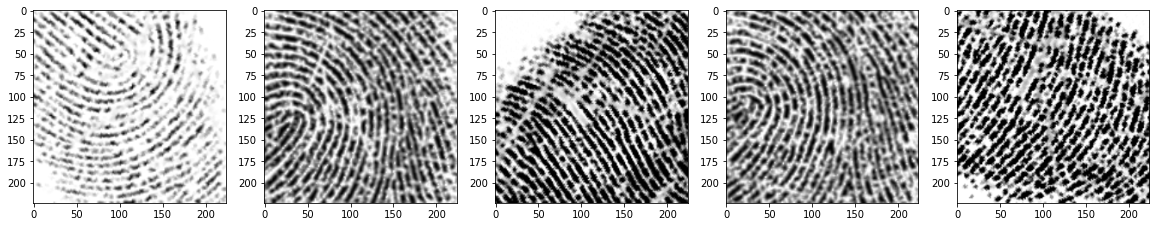

Reconstruction of Test Images


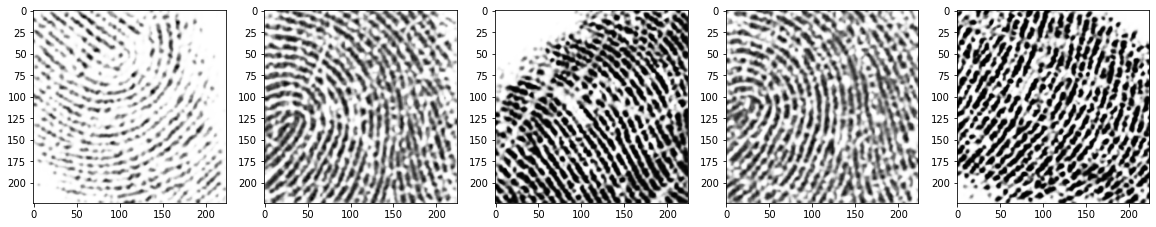

In [42]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

# Saving Model

In [44]:
autoencoder = encoder.save_weights('autoencoder.h5')


# Load Model As

>`autoencoder = Model(input_img, autoencoder(input_img))`

> `autoencoder.load_weights('autoencoder.h5')`

> ```autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())```

>


